In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Description of the project:
Are there some indications of a bear market in the finance market before it appears?
If we knew that, we could be cautious with our money and save some losses. 
In order to examine that, I would like to check the parameters below:
1. First, I would like to identify the periods of a bear market vs to the periods right before the bear market  
2. Then, I would like to examine the changes of the p/e ratio right before a bear market occurs.
3. Next, I would like to examine the changes of the US treasury yield of 2 years and 10 years,
   and see if anomaly occurs right before bear market appears. 
   Anomaly would be that the yield of 2 years bond is higher than 10 years bond.
4. Finally I would like to run a regression between the S&P500 price and the quarterly earning change rate of the S%P500 (top 500 companies)
   and see if there is a correlation between the two parameters. If there is, it might help to see a head a bear market coming...  

# The Data:
The S&P500 index price
The S&P500 p/e ratio
US treasury bonds yield for 2 years and for 10 years
The S&P500 earnings growth.
The period: through January 1990 to today - August 2019. Monthly. Except earning which is reported every quarter.  
links to the Data:
S&P 500 Price: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
S&P 500 P/E: https://www.quandl.com/data/MULTPL/SP500_PE_RATIO_MONTH-S-P-500-PE-Ratio-by-Month
Us Treasury Yields:  https://www.quandl.com/data/USTREASURY/YIELD-Treasury-Yield-Curve-Rates
S&P 500 earnings growth by quarter: https://www.quandl.com/data/MULTPL/SP500_EARNINGS_GROWTH_QUARTER-S-P-500-Earnings-Growth-Rate-by-Quarter 

In [27]:
# Open A data frame US Treasury yield. Monthly since January 1990. Source: Quandle
us_treasury_file = r'C:\Users\elcha\PycharmProjects\DA_final_project\USTREASURY-YIELD.csv'
us_treasury = pd.read_csv(us_treasury_file,index_col='Date', parse_dates=True, usecols=['Date','2 YR','10 YR'])

In [28]:
# Open A data frame of S&P 500 Price. Monthly since January 1990. Source: Yahoo Finance
SnP500_file = r'C:\Users\elcha\PycharmProjects\DA_final_project\^GSPC.csv'
price = pd.read_csv(SnP500_file, index_col='Date', parse_dates=True, usecols=['Adj Close', 'Date'])

In [29]:
# Open A data frame of S&P 500 P/E. Monthly since January 1990
SnP500_pe_file = r'C:\Users\elcha\PycharmProjects\DA_final_project\MULTPL-SP500_PE_RATIO_MONTH.csv'
pe = pd.read_csv(SnP500_pe_file, index_col='Date', parse_dates=True, usecols=['Value', 'Date'])
pe = pe.rename({'Value': 'P/E'} , axis=1)  # rename the column's name

In [30]:
# Join data frame of S&P 500 Price with the data frame of S&P 500 P/E , by their index - Date.
SnP500 = price.join(pe).dropna(axis=0)

In [31]:
# # Open A data frame of S&P 500 earning. Quarterly since December 1989. Source: Quandle
SnP500_earn_file = r'C:\Users\elcha\PycharmProjects\DA_final_project\MULTPL-SP500_EARNINGS_GROWTH_QUARTER.csv'
SnP500_earn = pd.read_csv(SnP500_earn_file,index_col='Date', parse_dates=True, usecols=['Value', 'Date'])
SnP500_earn = SnP500_earn.rename({'Value': 'Earning Growth Rate'} , axis=1)  # rename the column's name
SnP500_earn = SnP500_earn.sort_values('Date') # Sorting so we would be able later on joining it to the main S&P500 dataframe by quarter
SnP500_Q = pd.merge_asof(SnP500_earn[['Earning Growth Rate']],SnP500[['Adj Close']],on='Date',direction='nearest').set_index('Date')

In [32]:
# The Summary Data Tables and Summary Statistics:
print ("S&P 500 Price & P/E since January 1990 :\n", SnP500.head(), "\n")
print (SnP500.describe(), "\n")
print ("The S&P 500 earning quarterly growth since December 1989 :" ,"\n", SnP500_Q.head(),"\n")
print (SnP500_Q.describe(), "\n")
print ("US Treasury yields for 2Y & 10Y since January 1990 :\n", us_treasury.head(), "\n")
print (us_treasury.describe(), "\n")

S&P 500 Price & P/E since January 1990 :
              Adj Close    P/E
Date                         
1990-01-01  329.079987  15.13
1990-02-01  331.890015  14.97
1990-03-01  339.940002  15.62
1990-04-01  330.799988  15.70
1990-05-01  361.230011  16.37 

         Adj Close         P/E
count   356.000000  356.000000
mean   1249.952218   24.285028
std     650.474931   14.218966
min     304.000000   13.500000
25%     800.472519   17.917500
50%    1184.974976   21.455000
75%    1470.434998   25.212500
max    2980.379883  123.730000 

The S&P 500 earning quarterly growth since December 1989 : 
             Earning Growth Rate   Adj Close
Date                                       
1989-12-31                -3.71  329.079987
1990-03-31               -13.18  330.799988
1990-06-30               -15.70  356.149994
1990-09-30                -8.23  304.000000
1990-12-31                -6.69  343.929993 

       Earning Growth Rate    Adj Close
count           118.000000   118.000000
mean          

In [33]:
# Identify the periods of a bear market vs to the periods right before the bear market
SnP500['Change']= SnP500['Adj Close'].pct_change() # calculate the percentage change of the price
SnP500['Max 12'] = SnP500['Adj Close'].rolling(window=12).max() # To get the max price the last 12 months
SnP500['Max 12'].fillna(method='bfill', inplace=True) # filling values back
SnP500['Change from max']= SnP500['Adj Close']/SnP500['Max 12']-1 # calculating the price change vs the maximum price in the last 12 months
# Defining a bear market period as a drop over 20% from max price
SnP500['Bear'] = np.where(SnP500['Change from max']<-0.2, 'True', 'False')
SnP500[['Bear Price', 'Bear PE']] = SnP500[['Adj Close','P/E']][SnP500['Bear']=='True']

In [34]:
# Checking the p/e ratio movement to see later on if there's a development of a bubble before bear market occurs
# Adding a column of an average p/e over the last 12 months:
# SnP500['AVE PE 12'] = SnP500['P/E'].rolling(window=12).mean()
SnP500['PE Deviation'] = np.where(SnP500['P/E']> SnP500['P/E'].quantile(0.8), 'True', 'False') # Trying the Pareto rule
SnP500[['PE Deviation Value']] = SnP500[['P/E']][SnP500['PE Deviation']=='True']
print ('S&P 500 DATA : \n',  SnP500.head())

S&P 500 DATA : 
              Adj Close    P/E    Change      Max 12  Change from max   Bear  \
Date                                                                          
1990-01-01  329.079987  15.13       NaN  361.230011        -0.089002  False   
1990-02-01  331.890015  14.97  0.008539  361.230011        -0.081222  False   
1990-03-01  339.940002  15.62  0.024255  361.230011        -0.058938  False   
1990-04-01  330.799988  15.70 -0.026887  361.230011        -0.084240  False   
1990-05-01  361.230011  16.37  0.091989  361.230011         0.000000  False   

            Bear Price  Bear PE PE Deviation  PE Deviation Value  
Date                                                              
1990-01-01         NaN      NaN        False                 NaN  
1990-02-01         NaN      NaN        False                 NaN  
1990-03-01         NaN      NaN        False                 NaN  
1990-04-01         NaN      NaN        False                 NaN  
1990-05-01         NaN     

In [35]:
# Slicing the s&p 500 data to a data frame of the bear periods,
# just to get an idea of the bear periods at the last 3 decades (almost 3...)
bear = SnP500[SnP500['Bear']=='True']
print ("Bear periods :\n",bear, '\n') # We can see two periods of a bear market in the last 3 decades (3/2001 & 9/2008)

Bear periods :
               Adj Close     P/E    Change       Max 12  Change from max  Bear  \
Date                                                                            
2001-03-01  1160.329956   26.10 -0.064205  1517.680054        -0.235458  True   
2001-07-01  1211.229980   35.46 -0.010740  1517.680054        -0.201920  True   
2001-08-01  1133.579956   37.85 -0.064108  1436.510010        -0.210879  True   
2001-09-01  1040.939941   36.90 -0.081723  1429.400024        -0.271764  True   
2001-10-01  1059.780029   39.72  0.018099  1366.010010        -0.224178  True   
2002-07-01   911.619995   32.46 -0.079004  1148.079956        -0.205961  True   
2002-08-01   916.070007   31.53  0.004881  1148.079956        -0.202085  True   
2002-09-01   815.280029   28.89 -0.110024  1148.079956        -0.289875  True   
2002-10-01   885.760010   29.24  0.086449  1148.079956        -0.228486  True   
2002-12-01   879.820007   32.59 -0.060333  1147.390015        -0.233199  True   
2003-01-01  

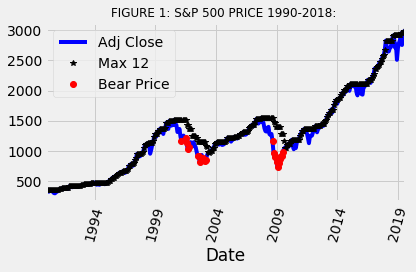

In [36]:
# Plotting the three lines of: 1) s&p 500 price. 2) bear price. 3) Maximum price for 12 months
SnP500[['Adj Close','Max 12','Bear Price']].plot(style=['b','k*','ro'])
plt.xticks(rotation=75)
plt.title('FIGURE 1: S&P 500 PRICE 1990-2018: ',fontsize=12)
plt.tight_layout()
plt.savefig('S&P 500 PRICE 1990-2018.png', fmt='png', dpi=200)
plt.show()

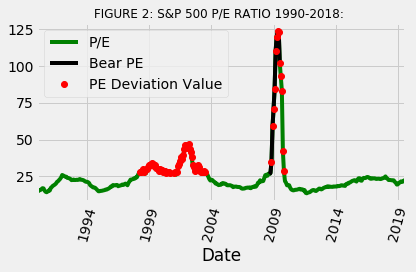

In [37]:
# Checking if the p/e ratio before bear market occurs indicates of a bubble (high p/e ratio)
# Three lines of: 1) s&p 500 p/e. 2) Bear p/e. 3) Deviation of the p/e
SnP500[['P/E','Bear PE','PE Deviation Value']].plot(style=['g','k','ro'])
plt.xticks(rotation=75)
plt.title('FIGURE 2: S&P 500 P/E RATIO 1990-2018: ',fontsize=12)
plt.tight_layout()
plt.savefig('S&P 500 PE RATIO 1990-2018.png', fmt='png', dpi=200)
plt.show()

#  It seems that before the first bear period of 2001-2003 there was a deviation of the p/e ratio.
The p/e was higher than the common p/e of 80% of the time before, which signal a bubble.
But the this deviation didn't occur before the second bear market of 2008-2009. Which means that there wasn't a bubble
At least not in the s&p 500 stocks, maybe at only one sector as we know - US housing market, that influenced the finance markets

In [38]:
# Checking for anomaly in treasury yield (whenever 2yr yield is higher than 10yr yield)
us_treasury['2YR > 10YR Yield'] = np.where(us_treasury['2 YR'] > us_treasury['10 YR'], us_treasury['2 YR'], np.nan)
us_treasury['2-10y Max Yield'] = us_treasury[['2 YR','10 YR']].max(axis=1) # Creating a column of the max yield each date between 2Y & 10Y
print ("US Treasury yields for 2Y & 10Y . Checking anomaly in the market :\n", us_treasury.head(), "\n")

US Treasury yields for 2Y & 10Y . Checking anomaly in the market :
             2 YR  10 YR  2YR > 10YR Yield  2-10y Max Yield
Date                                                      
2019-09-30  1.53   1.55               NaN             1.55
2019-08-31  1.50   1.50               NaN             1.50
2019-07-31  1.89   2.02               NaN             2.02
2019-06-30  1.75   2.00               NaN             2.00
2019-05-31  1.95   2.14               NaN             2.14 



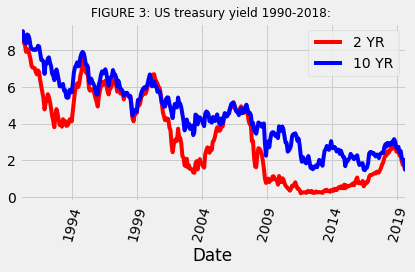

In [39]:
# Plotting two lines: 1) US treasury yield for 2 years. 2) US treasury yield for 10 years
us_treasury[['2 YR','10 YR']].plot(style=['r','b'])
plt.xticks(rotation=75)
plt.title('FIGURE 3: US treasury yield 1990-2018: ',fontsize=12)
plt.tight_layout()
plt.savefig('US treasury yield  1990-2018.png', fmt='png', dpi=200)
plt.show()

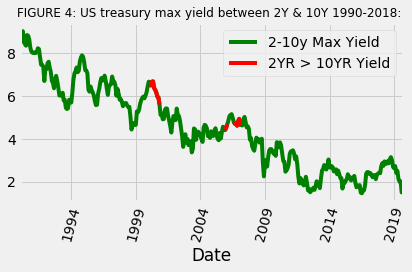

In [40]:
# Plotting two lines: 1) US treasury max yield between 2Y & 10 Y . 2) US treasury when 2 years yield is higher than 10 years
us_treasury[['2-10y Max Yield','2YR > 10YR Yield']].plot(style=['g','r'])
plt.xticks(rotation=75)
plt.title('FIGURE 4: US treasury max yield between 2Y & 10Y 1990-2018: ',fontsize=12)
plt.tight_layout()
plt.savefig('US treasury max yield  1990-2018.png', fmt='png', dpi=200)
plt.show()

In [41]:
# Merging SnP500 Value to the 2Y & 10Y treasury yield dataframe to plot this lines and check their values right before a bear market
market = pd.merge_asof(SnP500[['Adj Close']],us_treasury[['2-10y Max Yield','2YR > 10YR Yield']].sort_values('Date'),on='Date',direction='nearest').set_index('Date')
market['Bear Price'] = bear['Adj Close']
print ("US Market Finance 1990-2018 :\n", market.head(), "\n")

US Market Finance 1990-2018 :
              Adj Close  2-10y Max Yield  2YR > 10YR Yield  Bear Price
Date                                                                 
1990-01-01  329.079987             8.43               NaN         NaN
1990-02-01  331.890015             8.43               NaN         NaN
1990-03-01  339.940002             8.51               NaN         NaN
1990-04-01  330.799988             8.65               NaN         NaN
1990-05-01  361.230011             9.04               NaN         NaN 



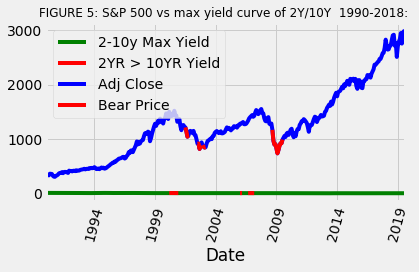

In [42]:
# Plotting four lines:
# 1) US treasury yield 2Y & 10 Y . Two lines combining to one. Marking in red when 2y yield is higher than 10y yield. Anomaly...
# 2) SnP500 price and price in a bear market . Two lines combining to one. Marking in red when it is a bear market price
market[['2-10y Max Yield','2YR > 10YR Yield','Adj Close','Bear Price']].plot(style=['g','r','b','r'])
plt.xticks(rotation=75)
plt.title('FIGURE 5: S&P 500 vs max yield curve of 2Y/10Y  1990-2018: ',fontsize=12)
plt.tight_layout()
plt.savefig('S&P 500 vs max yield curve of 2Y-10Y  1990-2018.png', fmt='png', dpi=200)
plt.show()

# It seems that before the first bear period of 2001-2003 there was a period where the 2y treasury yield was
higher than the 10y yield (3/2000-12/2000). But it was 7 months before the start of the bear market (7/2001)
The yield curve reversed back 7 months before the bear market.
Through January to March 2006 the yield of 2y yield was higher than 10y. Then itאturned over (March to September 2006)
And then again (September 2006 to March 2007) it fliiped over again (2y yield was higher than 10y yield).
The second bear market started at september 2008,
which means that it started one year after the treasury yield curve flipped over to normal (where 10y yield is higher than 2y yield)
That is, the bond yield curve reversal is indicative of a bear market, but it is ahead of it by about a 7 months to year

In [43]:
# Running a regression between the S$P500 price and the quarterly earning change rate of the S&P500 (top 500 companies)
# and see if there is a correlation between the two parameters. If there is, it might help to see a head a bear market coming..
print ('Coorelation between Earning growth rate of the S&P 500 and its price : \n',SnP500_Q.corr(), '\n')
# There's seems to be no correlation...

Coorelation between Earning growth rate of the S&P 500 and its price : 
                      Earning Growth Rate  Adj Close
Earning Growth Rate             1.000000   0.000431
Adj Close                       0.000431   1.000000 



In [44]:
# And yet , running a regression model...    
# With statsmodels using Ordinary Least Squares regression
x = SnP500_Q['Earning Growth Rate']  # response
y = SnP500_Q['Adj Close']  # predictor
x = sm.add_constant(x)  # Adds a constant term to the predictor
result=sm.OLS(y, x).fit() #Fit the model and print output
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                 2.152e-05
Date:                Fri, 25 Oct 2019   Prob (F-statistic):              0.996
Time:                        15:38:23   Log-Likelihood:                -929.17
No. Observations:                 118   AIC:                             1862.
Df Residuals:                     116   BIC:                             1868.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1236.0464    

C:\Users\elcha\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


            Earning Growth Rate    Adj Close            Y
Date                                                     
1989-12-31                -3.71   329.079987  1236.037522
1990-03-31               -13.18   330.799988  1236.014893
1990-06-30               -15.70   356.149994  1236.008872
1990-09-30                -8.23   304.000000  1236.026721
1990-12-31                -6.69   343.929993  1236.030401
...                         ...          ...          ...
2018-03-31                15.11  2648.050049  1236.082493
2018-06-30                17.75  2816.290039  1236.088802
2018-09-30                21.77  2711.739990  1236.098408
2018-12-31                20.49  2704.100098  1236.095349
2019-03-31                16.42  2945.830078  1236.085624

[118 rows x 3 columns]


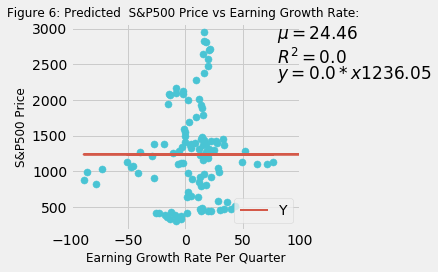

In [45]:
# Plotting a scatter plot of Adj Close vs. Earning Growth Rate add the best fit line and show its formula and R-squered¶
SnP500_q = SnP500_Q.copy()
Y=SnP500_q["Adj Close"]
X=SnP500_q["Earning Growth Rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)

line = slope*X+intercept # Find the line plot
SnP500_q['Y'] = line # adding a column called Y to the dataframe
print (SnP500_q)
# Add a figure and set axis (e.i. fig, ax=plt.subplots())
fig, ax = plt.subplots()
# Creating scatter plot and line
SnP500_q.plot.scatter(x='Earning Growth Rate', y='Adj Close', color='#49c4d4', ax=ax, s=50)
SnP500_q.plot('Earning Growth Rate', "Y", color='#d45949', linewidth=2, ax=ax)

# Setting axis x lim
plt.xlim(-100,100)

# Adding a text using these coordinates:
# x = 80
# y (for R-suared and mu) = 2500
# y (for the line formula) = 2300

r_squared = np.round(r_value**2, decimals=2)
mu = np.round(SnP500_q["Earning Growth Rate"].mean(), decimals=2)

plt.text(80, 2500, '$\mu={0}$ \n$R^2={1}$'.format(mu, r_squared), fontsize=17)
plt.text(80, 2300, '$y={0}*x{1}$'.format(np.round(slope, decimals=2),np.round(intercept, decimals=2)), fontsize=17)
plt.legend(loc='lower right')

plt.xlabel('Earning Growth Rate Per Quarter',fontsize=12)
plt.ylabel('S&P500 Price',fontsize=12)
plt.title('Figure 6: Predicted  S&P500 Price vs Earning Growth Rate: ',fontsize=12)
fig.tight_layout()
plt.savefig('S&P500 Price vs. Earning Growth Rate.png', fmt='png', dpi=100)
# As We saw before, there is no correlation between the quarterly earning growth of the companies of the S&P500 Index
# to the S&P500 price (Adj Close price)
plt.show()